<a href="https://colab.research.google.com/github/wiatrak2/BScThesis/blob/master/SVHNvsMnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load data

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('BScThesis/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip3 install torch torchvision

In [3]:
!git clone https://github.com/wiatrak2/BScThesis

Cloning into 'BScThesis'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 242 (delta 32), reused 34 (delta 13), pack-reused 179
Receiving objects: 100% (242/242), 18.84 MiB | 8.71 MiB/s, done.
Resolving deltas: 100% (131/131), done.


In [0]:
from importlib import reload 

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
import torchvision
import torchvision.transforms as transforms

In [0]:
import matplotlib.pyplot as plt
import pickle
import sympy
from collections import defaultdict, namedtuple
import copy

In [0]:
from mnist_m import Mnist_M
import datasets_merge
import models
import svhn_models
import trainer
import domain_trainer
from test_model import test_model
import plots
import test

In [0]:
def convertMnist(img):
  img = img.squeeze().numpy()
  return torch.from_numpy(np.tile(img, (3,1,1)))

In [0]:
batch_size=128
num_workers=1

In [0]:
mnist_transform=transforms.Compose([
                           transforms.Resize((32,32)),    
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           transforms.Lambda(convertMnist)
                       ])

mnist_train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True,
                                     transform=mnist_transform)
mnist_train_loader = torch.utils.data.DataLoader(mnist_train_set, batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)

mnist_test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True,
                                     transform=mnist_transform)
mnist_test_loader = torch.utils.data.DataLoader(mnist_test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)



In [0]:
def printMnist3D(image):
  image = image.numpy()
  image = image * 0.5 + 0.5
  plt.imshow(image.transpose(1,2,0), cmap='gray')

1


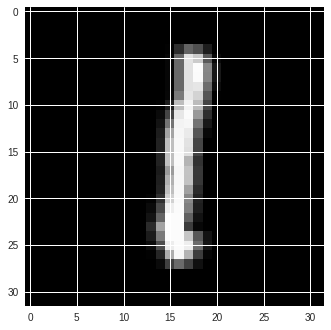

In [31]:
trainiter = iter(mnist_train_loader)
images, labels = trainiter.next()

sample = images[0]
printMnist3D(sample)
print(labels[0].item())

In [32]:
svhn_transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                       ])

svhn_train_set = torchvision.datasets.SVHN(root='./data', download=True,
                                     transform=svhn_transform)
svhn_train_loader = torch.utils.data.DataLoader(svhn_train_set, batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)

svhn_test_set = torchvision.datasets.SVHN(root='./data',  download=True,
                                     transform=svhn_transform)
svhn_test_loader = torch.utils.data.DataLoader(svhn_test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=num_workers)




Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/train_32x32.mat


2


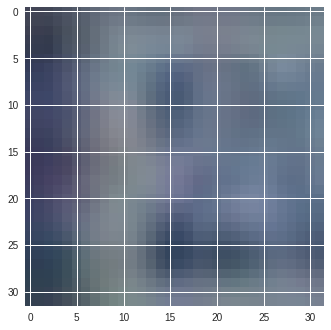

In [33]:
trainiter = iter(svhn_train_loader)
images, labels = trainiter.next()

sample = images[0]
printMnist3D(sample)
print(labels[0].item())

In [0]:
merge_train_set = datasets_merge.Merge_Datasets([mnist_train_set, svhn_train_set], get_labels=False)
merge_test_set = datasets_merge.Merge_Datasets([mnist_test_set, svhn_test_set], get_labels=False)
merge_train_loader = torch.utils.data.DataLoader(merge_train_set, 
                                                   batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)
merge_test_loader = torch.utils.data.DataLoader(merge_test_set, 
                                                   batch_size=batch_size,
                                         shuffle=True, num_workers=num_workers)

In [0]:
log_interval = 100

In [0]:
use_cuda = True
use_cuda = use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [0]:
lr = 0.01
momentum=0.9

In [0]:
Models = namedtuple('Models', ['model_f', 'model_c', 'model_d'])
Optims = namedtuple('Optims', ['optim_f', 'optim_c', 'optim_d'])
Criterions = namedtuple('Criterions', ['criterion', 'criterion_domain'])
Loaders = namedtuple('Loaders', ['train_loader', 'train_loader_domain',
                                'source_test_loader', 'target_test_loader',
                                'merged_test_loader'])

In [0]:
loaders = Loaders(svhn_train_loader, mnist_train_loader, 
                 svhn_test_loader, mnist_test_loader, merge_test_loader)

In [0]:
criterion = F.nll_loss
criterion_domain = F.nll_loss

In [0]:
criterions = Criterions(criterion, criterion_domain)

In [0]:
epochs=18

# Get models

In [0]:
model_f = svhn_models.SvhnFeatureExtractor([3,48, 64, 128, 160, 192], pool_stride=2, pool_padding=1).to(device)

In [62]:
output_size = model_f.get_output_size(device)[1]
output_size

768

In [0]:
mf = [output_size]
mc = [output_size, 3072, 2048, 512]
md = [output_size, 1024, 100]

In [0]:
_, model_c, model_d = models.get_models(mf, mc, md, use_gr=True)
model_f, model_c, model_d = model_f.to(device), model_c.to(device), model_d.to(device)

In [0]:
lr=0.01
optim_f = optim.SGD(model_f.parameters(), lr=lr, momentum=momentum)
optim_c = optim.SGD(model_c.parameters(), lr=lr, momentum=momentum)
optim_d = optim.SGD(model_d.parameters(), lr=lr, momentum=momentum)

In [0]:
train_models = Models(model_f, model_c, model_d)
optims = Optims(optim_f, optim_c, optim_d)

# First training

In [0]:
model_trainer_gr = trainer.Trainer(train_models, optims, criterions, device, train_domain=True, tune_lr=True)

In [68]:
test_history_gr = defaultdict(lambda:[])
model_trainer_gr.train(epochs, loaders, test_history=test_history_gr)

Train Epoch: 					1 [0/73257 (0%)]	Loss: 2.301327, lr: 0.01000 lambd: 0.00000
Train Epoch: 					1 [12800/73257 (17%)]	Loss: 2.254705, lr: 0.00933 lambd: 0.04850
Train Epoch: 					1 [25600/73257 (35%)]	Loss: 2.189312, lr: 0.00875 lambd: 0.09677
Train Epoch: 					1 [38400/73257 (52%)]	Loss: 2.196675, lr: 0.00826 lambd: 0.14459
Train Epoch: 					1 [51200/73257 (70%)]	Loss: 2.133082, lr: 0.00782 lambd: 0.19174

Target Domain Test set: Average loss: 2.1691, Accuracy: 1844/10000 (18%)
Source Domain Test set: Average loss: 2.2343, Accuracy: 14638/73257 (20%)
Domains predictor:  Accuracy: 65716/83257 (79%)

Train Epoch: 					2 [0/73257 (0%)]	Loss: 2.065847, lr: 0.00718 lambd: 0.27085
Train Epoch: 					2 [12800/73257 (17%)]	Loss: 1.997819, lr: 0.00686 lambd: 0.31520
Train Epoch: 					2 [25600/73257 (35%)]	Loss: 1.970345, lr: 0.00657 lambd: 0.35823
Train Epoch: 					2 [38400/73257 (52%)]	Loss: 2.062957, lr: 0.00631 lambd: 0.39978
Train Epoch: 					2 [51200/73257 (70%)]	Loss: 1.791197, lr: 0.0060

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7fe90a0a0160>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  Fil


Target Domain Test set: Average loss: 1.2218, Accuracy: 6050/10000 (60%)
Source Domain Test set: Average loss: 0.5630, Accuracy: 60549/73257 (83%)
Domains predictor:  Accuracy: 10820/83257 (13%)

Train Epoch: 					7 [0/73257 (0%)]	Loss: 0.711647, lr: 0.00333 lambd: 0.93111
Train Epoch: 					7 [12800/73257 (17%)]	Loss: 0.560645, lr: 0.00327 lambd: 0.93728
Train Epoch: 					7 [25600/73257 (35%)]	Loss: 0.938771, lr: 0.00322 lambd: 0.94292
Train Epoch: 					7 [38400/73257 (52%)]	Loss: 0.510046, lr: 0.00317 lambd: 0.94806
Train Epoch: 					7 [51200/73257 (70%)]	Loss: 0.555990, lr: 0.00312 lambd: 0.95275


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7fe90a0a0f98>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  Fil


Target Domain Test set: Average loss: 1.4755, Accuracy: 5651/10000 (57%)
Source Domain Test set: Average loss: 0.4850, Accuracy: 62765/73257 (86%)
Domains predictor:  Accuracy: 17248/83257 (21%)

Train Epoch: 					8 [0/73257 (0%)]	Loss: 0.743810, lr: 0.00304 lambd: 0.95988
Train Epoch: 					8 [12800/73257 (17%)]	Loss: 0.763839, lr: 0.00300 lambd: 0.96353
Train Epoch: 					8 [25600/73257 (35%)]	Loss: 0.683719, lr: 0.00295 lambd: 0.96685
Train Epoch: 					8 [38400/73257 (52%)]	Loss: 0.708999, lr: 0.00291 lambd: 0.96987
Train Epoch: 					8 [51200/73257 (70%)]	Loss: 0.479500, lr: 0.00287 lambd: 0.97262

Target Domain Test set: Average loss: 1.3440, Accuracy: 5649/10000 (56%)
Source Domain Test set: Average loss: 0.4377, Accuracy: 63685/73257 (87%)
Domains predictor:  Accuracy: 10435/83257 (13%)

Train Epoch: 					9 [0/73257 (0%)]	Loss: 0.672807, lr: 0.00281 lambd: 0.97679
Train Epoch: 					9 [12800/73257 (17%)]	Loss: 0.493759, lr: 0.00277 lambd: 0.97891
Train Epoch: 					9 [25600/73257 (3

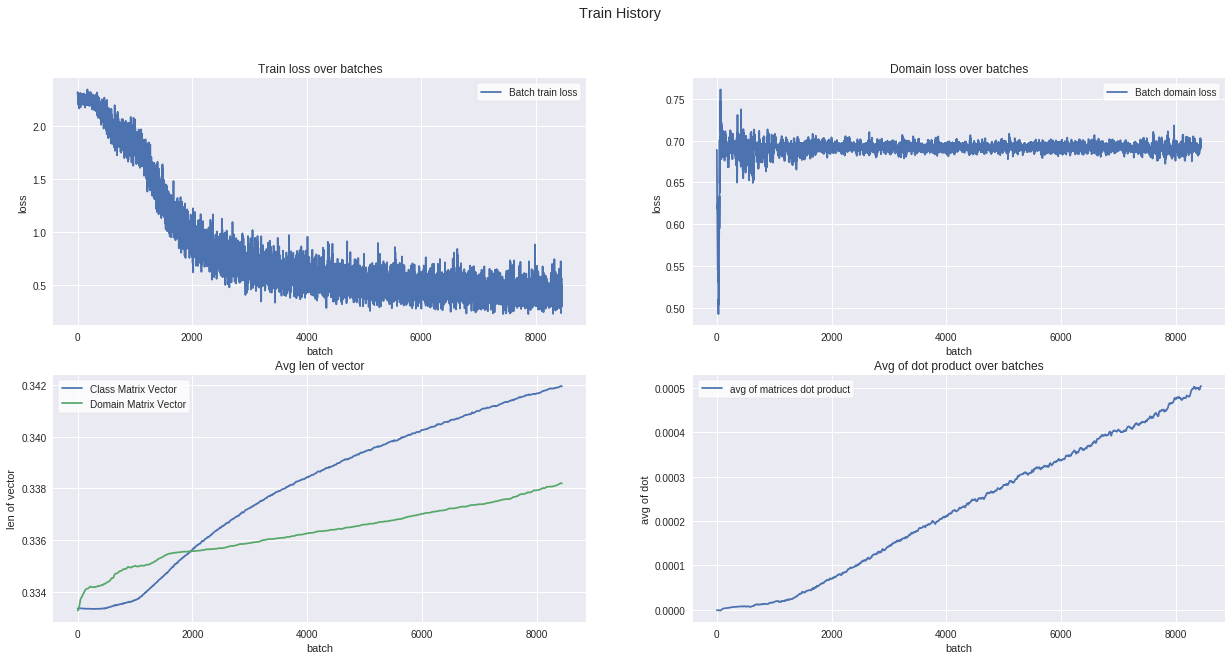

In [69]:
plots.plot_training(model_trainer_gr.train_history)

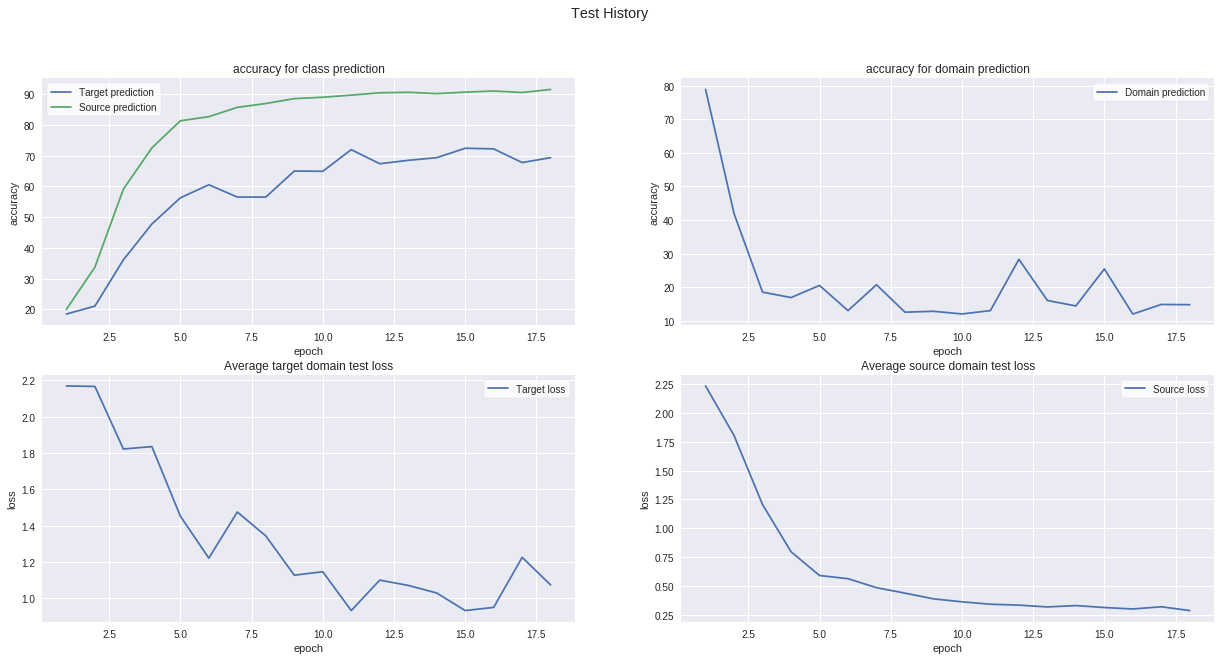

In [70]:
plots.plot_test(test_history_gr)

In [0]:
new_trainer = copy.deepcopy(model_trainer_gr)

In [0]:
new_trainer2 = copy.deepcopy(model_trainer_gr)

# Getting Domain Predictor on trained model

In [0]:
_, _, domain_pred = models.get_models(mf, mc, md, use_gr=False)
domain_pred = domain_pred.to(device)

In [0]:
domain_optim = optim.SGD(domain_pred.parameters(), lr=lr, momentum=momentum)

In [0]:
models_dom = Models(model_f, None, domain_pred)
optims_dom = Optims(None, None, optim_d=domain_optim)
new_domain_trainer = domain_trainer.DomainTrainer(models_dom, optims_dom, criterions, device)

In [76]:
domain_train_history = defaultdict(lambda:[])
new_domain_trainer.train(4, loaders, train_models, train_history=domain_train_history)

Train Epoch: 1 [0/83257 (0%)]	Loss: 0.681193
Train Epoch: 1 [12800/83257 (15%)]	Loss: 0.296182
Train Epoch: 1 [25600/83257 (31%)]	Loss: 0.204598
Train Epoch: 1 [38400/83257 (46%)]	Loss: 0.074736
Train Epoch: 1 [51200/83257 (61%)]	Loss: 0.100569
Train Epoch: 1 [64000/83257 (77%)]	Loss: 0.018429
Train Epoch: 1 [76800/83257 (92%)]	Loss: 0.030970

Domains predictor:  Accuracy: 82928/83257 (100%)

Train Epoch: 2 [0/83257 (0%)]	Loss: 0.040172
Train Epoch: 2 [12800/83257 (15%)]	Loss: 0.005735
Train Epoch: 2 [25600/83257 (31%)]	Loss: 0.006473
Train Epoch: 2 [38400/83257 (46%)]	Loss: 0.031110
Train Epoch: 2 [51200/83257 (61%)]	Loss: 0.037588
Train Epoch: 2 [64000/83257 (77%)]	Loss: 0.028093
Train Epoch: 2 [76800/83257 (92%)]	Loss: 0.008055

Domains predictor:  Accuracy: 83160/83257 (100%)

Train Epoch: 3 [0/83257 (0%)]	Loss: 0.018085
Train Epoch: 3 [12800/83257 (15%)]	Loss: 0.005586
Train Epoch: 3 [25600/83257 (31%)]	Loss: 0.003826
Train Epoch: 3 [38400/83257 (46%)]	Loss: 0.002851
Train Epoch: 

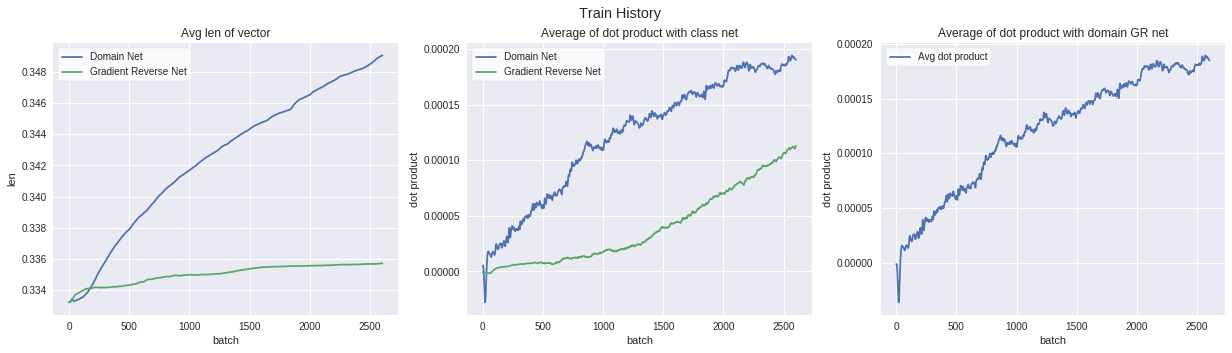

In [77]:
plots.plot_domain_training(domain_train_history, model_trainer_gr.train_history)

# Adding GR to Domain Predictor

In [0]:
_, _, domain_pred_gr = models.get_models(mf, mc, md, use_gr=True)
domain_pred_gr.load_state_dict(domain_pred.state_dict())
domain_pred_gr = domain_pred_gr.to(device)
new_optim_d = optim.SGD(domain_pred_gr.parameters(), lr=lr, momentum=momentum, nesterov=True)

In [79]:
dom_pr = nn.Sequential(model_f, domain_pred_gr)
domain_trainer.DomainTrainer.test_domain_pred(dom_pr, device, merge_test_loader)


Domains predictor:  Accuracy: 83154/83257 (100%)



In [0]:
new_domain_train_models = Models(model_f, model_c, domain_pred_gr)
new_domain_train_optims = Optims(optim_f, optim_c, new_optim_d)

In [0]:
domain_trainer_gr = trainer.Trainer(new_domain_train_models, new_domain_train_optims, criterions, device, tune_lr=True)

In [82]:
test_history_dom_gr = defaultdict(lambda:[])
domain_trainer_gr.train(5, loaders, test_history=test_history_dom_gr)

Train Epoch: 					1 [0/73257 (0%)]	Loss: 0.407262, lr: 0.01000 lambd: 0.00000
Train Epoch: 					1 [12800/73257 (17%)]	Loss: 0.427651, lr: 0.00799 lambd: 0.17297
Train Epoch: 					1 [25600/73257 (35%)]	Loss: 0.410094, lr: 0.00672 lambd: 0.33589
Train Epoch: 					1 [38400/73257 (52%)]	Loss: 0.417899, lr: 0.00584 lambd: 0.48092
Train Epoch: 					1 [51200/73257 (70%)]	Loss: 0.349949, lr: 0.00519 lambd: 0.60368

Target Domain Test set: Average loss: 1.0309, Accuracy: 7177/10000 (72%)
Source Domain Test set: Average loss: 0.2689, Accuracy: 67521/73257 (92%)
Domains predictor:  Accuracy: 38952/83257 (47%)

Train Epoch: 					2 [0/73257 (0%)]	Loss: 0.313947, lr: 0.00439 lambd: 0.76159
Train Epoch: 					2 [12800/73257 (17%)]	Loss: 0.594361, lr: 0.00404 lambd: 0.82578
Train Epoch: 					2 [25600/73257 (35%)]	Loss: 0.273392, lr: 0.00375 lambd: 0.87392
Train Epoch: 					2 [38400/73257 (52%)]	Loss: 0.369114, lr: 0.00350 lambd: 0.90942
Train Epoch: 					2 [51200/73257 (70%)]	Loss: 0.295550, lr: 0.0032

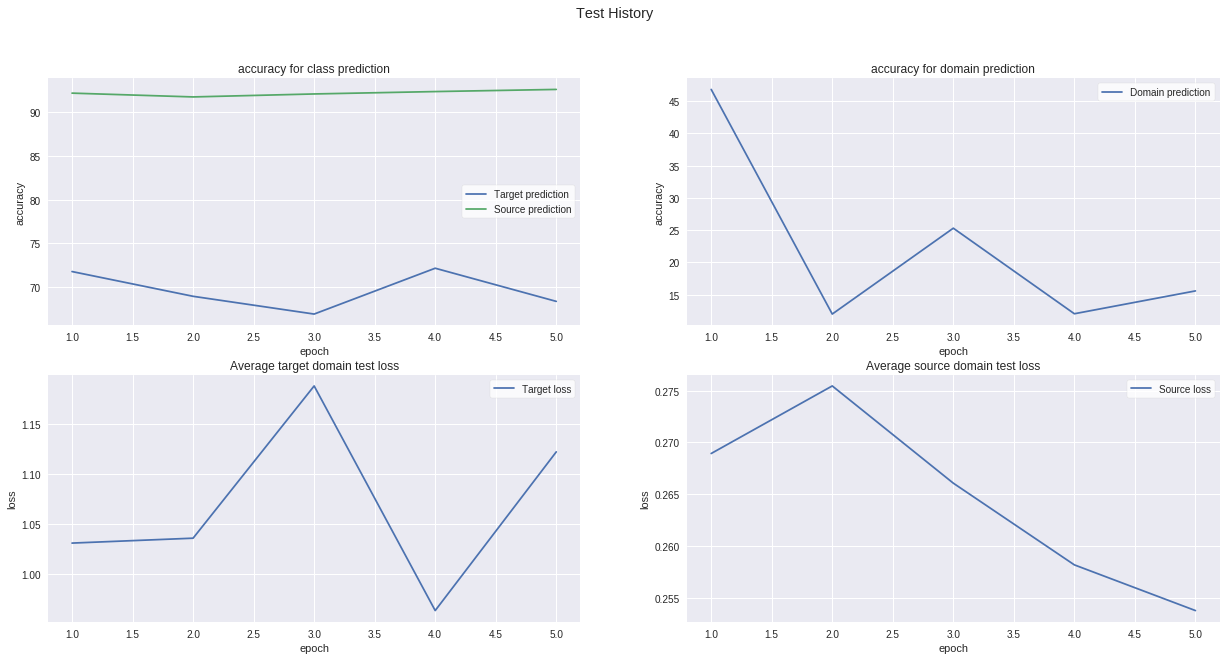

In [83]:
plots.plot_test(test_history_dom_gr)

# Getting next Domain Predictor

In [0]:
_, _, domain_pred_gr_new = models.get_models(mf, mc, md, use_gr=True)
domain_pred_gr_new = domain_pred_gr_new.to(device)
new_optim_d = optim.SGD(domain_pred_gr_new.parameters(), lr=lr, momentum=momentum, nesterov=True)

In [0]:
new_domain_train_models = Models(model_f, None, domain_pred_gr_new)
new_domain_train_optims = Optims(None, None, optim_d=new_optim_d)

In [0]:
new_domain_trainer = domain_trainer.DomainTrainer(new_domain_train_models, new_domain_train_optims, criterions, device)

In [87]:
domain_train_history = defaultdict(lambda:[])
new_domain_trainer.train(6, loaders, train_models, train_history=domain_train_history)

Train Epoch: 1 [0/83257 (0%)]	Loss: 0.651185
Train Epoch: 1 [12800/83257 (15%)]	Loss: 0.304125
Train Epoch: 1 [25600/83257 (31%)]	Loss: 0.260499
Train Epoch: 1 [38400/83257 (46%)]	Loss: 0.067965
Train Epoch: 1 [51200/83257 (61%)]	Loss: 0.041121
Train Epoch: 1 [64000/83257 (77%)]	Loss: 0.037920
Train Epoch: 1 [76800/83257 (92%)]	Loss: 0.019463

Domains predictor:  Accuracy: 82830/83257 (99%)

Train Epoch: 2 [0/83257 (0%)]	Loss: 0.021575
Train Epoch: 2 [12800/83257 (15%)]	Loss: 0.008094
Train Epoch: 2 [25600/83257 (31%)]	Loss: 0.006581
Train Epoch: 2 [38400/83257 (46%)]	Loss: 0.020065
Train Epoch: 2 [51200/83257 (61%)]	Loss: 0.016646
Train Epoch: 2 [64000/83257 (77%)]	Loss: 0.015359
Train Epoch: 2 [76800/83257 (92%)]	Loss: 0.003956

Domains predictor:  Accuracy: 83116/83257 (100%)

Train Epoch: 3 [0/83257 (0%)]	Loss: 0.006531
Train Epoch: 3 [12800/83257 (15%)]	Loss: 0.004226
Train Epoch: 3 [25600/83257 (31%)]	Loss: 0.007392
Train Epoch: 3 [38400/83257 (46%)]	Loss: 0.008024
Train Epoch: 3

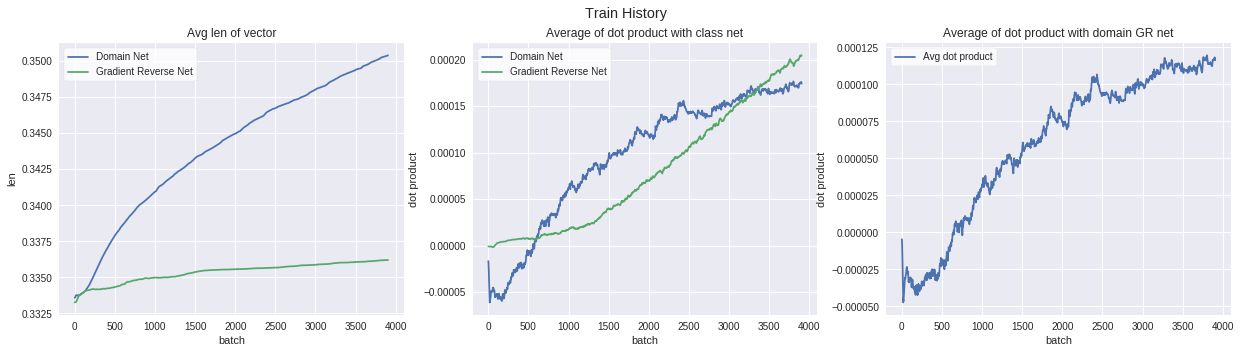

In [88]:
plots.plot_domain_training(domain_train_history, model_trainer_gr.train_history)

# Continuations of training

## Minimize dot product of models' martices

In [0]:
def mtx_dot(model_f, model_c, model_d, *args):
  return torch.mean(torch.pow(torch.mm(model_c.get_mtx().weight, torch.transpose(model_d.get_mtx().weight, 0, 1)), 2))

In [90]:
test_history_next = defaultdict(lambda:[])
new_trainer.train(8, loaders, mtx_dot, test_history=test_history_next)

Train Epoch: 					1 [0/73257 (0%)]	Loss: 0.421878, lr: 0.01000 lambd: 0.00000
Train Epoch: 					1 [12800/73257 (17%)]	Loss: 0.410504, lr: 0.00862 lambd: 0.10877
Train Epoch: 					1 [25600/73257 (35%)]	Loss: 0.386690, lr: 0.00762 lambd: 0.21500
Train Epoch: 					1 [38400/73257 (52%)]	Loss: 0.420879, lr: 0.00685 lambd: 0.31637
Train Epoch: 					1 [51200/73257 (70%)]	Loss: 0.367406, lr: 0.00624 lambd: 0.41100

Target Domain Test set: Average loss: 0.9448, Accuracy: 7238/10000 (72%)
Source Domain Test set: Average loss: 0.2717, Accuracy: 67375/73257 (92%)
Domains predictor:  Accuracy: 10683/83257 (13%)

Train Epoch: 					2 [0/73257 (0%)]	Loss: 0.294038, lr: 0.00544 lambd: 0.55460
Train Epoch: 					2 [12800/73257 (17%)]	Loss: 0.481491, lr: 0.00508 lambd: 0.62563
Train Epoch: 					2 [25600/73257 (35%)]	Loss: 0.452980, lr: 0.00477 lambd: 0.68761
Train Epoch: 					2 [38400/73257 (52%)]	Loss: 0.393372, lr: 0.00449 lambd: 0.74096
Train Epoch: 					2 [51200/73257 (70%)]	Loss: 0.377043, lr: 0.0042

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7fe910f8e9e8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  Fil


Target Domain Test set: Average loss: 0.9085, Accuracy: 7422/10000 (74%)
Source Domain Test set: Average loss: 0.2622, Accuracy: 67644/73257 (92%)
Domains predictor:  Accuracy: 11190/83257 (13%)

Train Epoch: 					6 [0/73257 (0%)]	Loss: 0.404277, lr: 0.00226 lambd: 0.99615
Train Epoch: 					6 [12800/73257 (17%)]	Loss: 0.295171, lr: 0.00221 lambd: 0.99690
Train Epoch: 					6 [25600/73257 (35%)]	Loss: 0.410323, lr: 0.00217 lambd: 0.99751
Train Epoch: 					6 [38400/73257 (52%)]	Loss: 0.254398, lr: 0.00212 lambd: 0.99800
Train Epoch: 					6 [51200/73257 (70%)]	Loss: 0.362351, lr: 0.00208 lambd: 0.99839

Target Domain Test set: Average loss: 0.8575, Accuracy: 7579/10000 (76%)
Source Domain Test set: Average loss: 0.2545, Accuracy: 67787/73257 (93%)
Domains predictor:  Accuracy: 19975/83257 (24%)

Train Epoch: 					7 [0/73257 (0%)]	Loss: 0.262320, lr: 0.00201 lambd: 0.99889
Train Epoch: 					7 [12800/73257 (17%)]	Loss: 0.304171, lr: 0.00197 lambd: 0.99911
Train Epoch: 					7 [25600/73257 (3

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7fe909710400>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  Fil


Target Domain Test set: Average loss: 0.9383, Accuracy: 7228/10000 (72%)
Source Domain Test set: Average loss: 0.2387, Accuracy: 68219/73257 (93%)
Domains predictor:  Accuracy: 16822/83257 (20%)



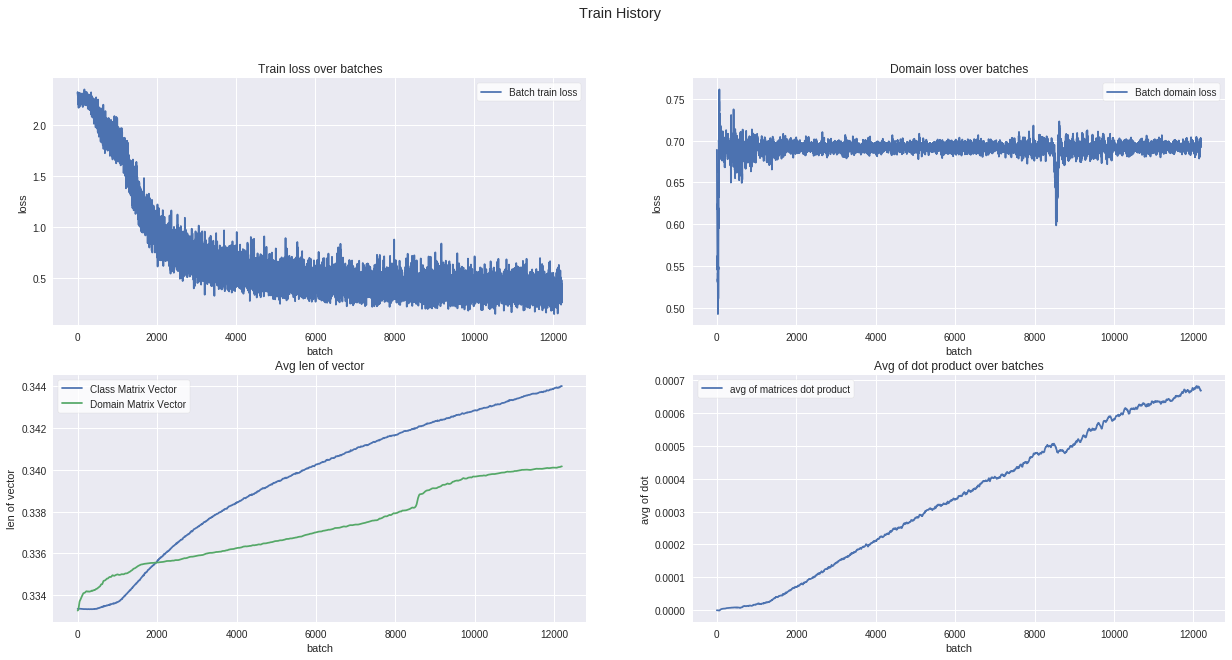

In [91]:
plots.plot_training(new_trainer.train_history)

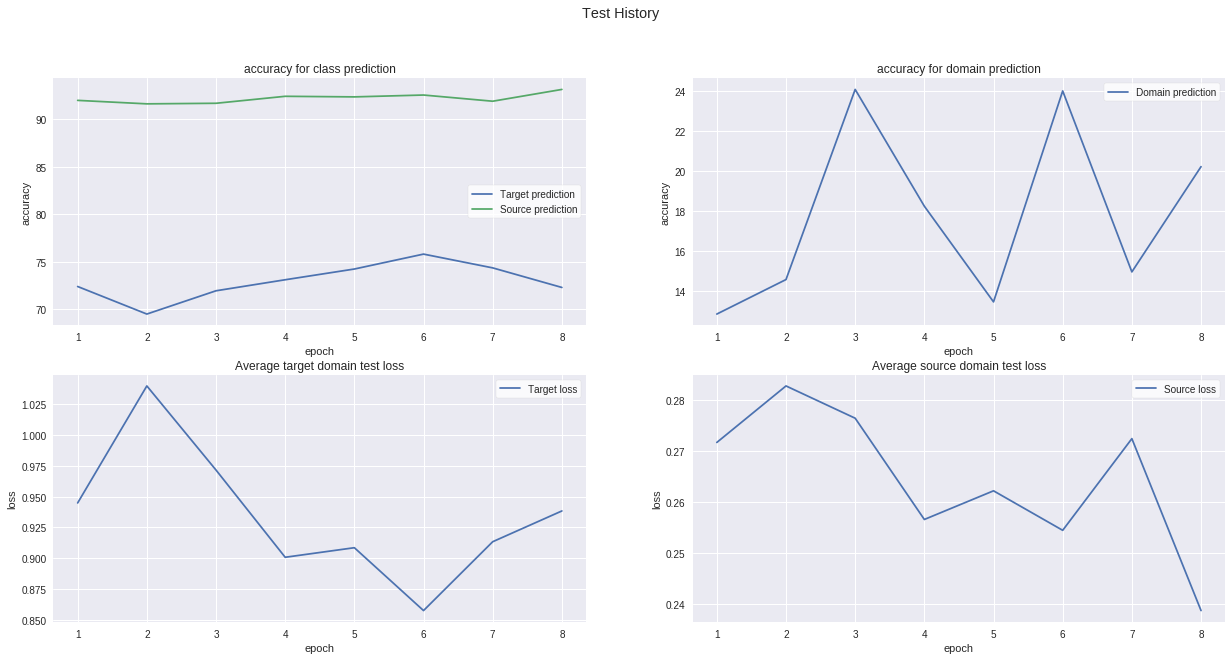

In [92]:
plots.plot_test(test_history_next)

## Minimize models' dot product and vector lengths

In [0]:
def mtx_dot_lens(model_c_len, model_d_len):
  def f(*args):
    model_f, model_c, model_d, *args = args
    return torch.mean(torch.pow(torch.mm(model_c.get_mtx().weight, torch.transpose(
        model_d.get_mtx().weight, 0, 1)), 2)) + torch.abs(model_c_len - torch.mean(
        torch.diag(torch.mm(model_c.get_mtx().weight, torch.transpose(
        model_c.get_mtx().weight, 0, 1))))) + torch.abs(model_d_len - torch.mean(
        torch.diag(torch.mm(model_d.get_mtx().weight, torch.transpose(
        model_d.get_mtx().weight, 0, 1)))))
  return f

In [94]:
test_history_next2 = defaultdict(lambda:[])
f = mtx_dot_lens(0, 0)
new_trainer2.train(8, loaders, f, test_history=test_history_next2)

Train Epoch: 					1 [0/73257 (0%)]	Loss: 1.066819, lr: 0.01000 lambd: 0.00000
Train Epoch: 					1 [12800/73257 (17%)]	Loss: 1.124797, lr: 0.00862 lambd: 0.10877
Train Epoch: 					1 [25600/73257 (35%)]	Loss: 1.067606, lr: 0.00762 lambd: 0.21500
Train Epoch: 					1 [38400/73257 (52%)]	Loss: 1.013152, lr: 0.00685 lambd: 0.31637
Train Epoch: 					1 [51200/73257 (70%)]	Loss: 0.871762, lr: 0.00624 lambd: 0.41100


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7fe90960b400>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  Fil


Target Domain Test set: Average loss: 0.9598, Accuracy: 7307/10000 (73%)
Source Domain Test set: Average loss: 0.2682, Accuracy: 67427/73257 (92%)
Domains predictor:  Accuracy: 20976/83257 (25%)

Train Epoch: 					2 [0/73257 (0%)]	Loss: 1.028064, lr: 0.00544 lambd: 0.55460
Train Epoch: 					2 [12800/73257 (17%)]	Loss: 0.961623, lr: 0.00508 lambd: 0.62563
Train Epoch: 					2 [25600/73257 (35%)]	Loss: 0.918013, lr: 0.00477 lambd: 0.68761
Train Epoch: 					2 [38400/73257 (52%)]	Loss: 1.012646, lr: 0.00449 lambd: 0.74096
Train Epoch: 					2 [51200/73257 (70%)]	Loss: 0.866836, lr: 0.00426 lambd: 0.78636

Target Domain Test set: Average loss: 1.0554, Accuracy: 7189/10000 (72%)
Source Domain Test set: Average loss: 0.2905, Accuracy: 66987/73257 (91%)
Domains predictor:  Accuracy: 30382/83257 (36%)

Train Epoch: 					3 [0/73257 (0%)]	Loss: 0.844961, lr: 0.00391 lambd: 0.84828
Train Epoch: 					3 [12800/73257 (17%)]	Loss: 0.888759, lr: 0.00373 lambd: 0.87621
Train Epoch: 					3 [25600/73257 (3

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7fe90960bb00>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  Fil


Target Domain Test set: Average loss: 0.9423, Accuracy: 7371/10000 (74%)
Source Domain Test set: Average loss: 0.2476, Accuracy: 68002/73257 (93%)
Domains predictor:  Accuracy: 25741/83257 (31%)

Train Epoch: 					6 [0/73257 (0%)]	Loss: 0.623102, lr: 0.00226 lambd: 0.99615
Train Epoch: 					6 [12800/73257 (17%)]	Loss: 0.587678, lr: 0.00221 lambd: 0.99690
Train Epoch: 					6 [25600/73257 (35%)]	Loss: 0.672834, lr: 0.00217 lambd: 0.99751
Train Epoch: 					6 [38400/73257 (52%)]	Loss: 0.618128, lr: 0.00212 lambd: 0.99800
Train Epoch: 					6 [51200/73257 (70%)]	Loss: 0.533758, lr: 0.00208 lambd: 0.99839

Target Domain Test set: Average loss: 0.8609, Accuracy: 7590/10000 (76%)
Source Domain Test set: Average loss: 0.2453, Accuracy: 68056/73257 (93%)
Domains predictor:  Accuracy: 18626/83257 (22%)

Train Epoch: 					7 [0/73257 (0%)]	Loss: 0.619039, lr: 0.00201 lambd: 0.99889
Train Epoch: 					7 [12800/73257 (17%)]	Loss: 0.556542, lr: 0.00197 lambd: 0.99911
Train Epoch: 					7 [25600/73257 (3

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7fe909247828>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  Fil


Target Domain Test set: Average loss: 0.9850, Accuracy: 7212/10000 (72%)
Source Domain Test set: Average loss: 0.2303, Accuracy: 68350/73257 (93%)
Domains predictor:  Accuracy: 50632/83257 (61%)



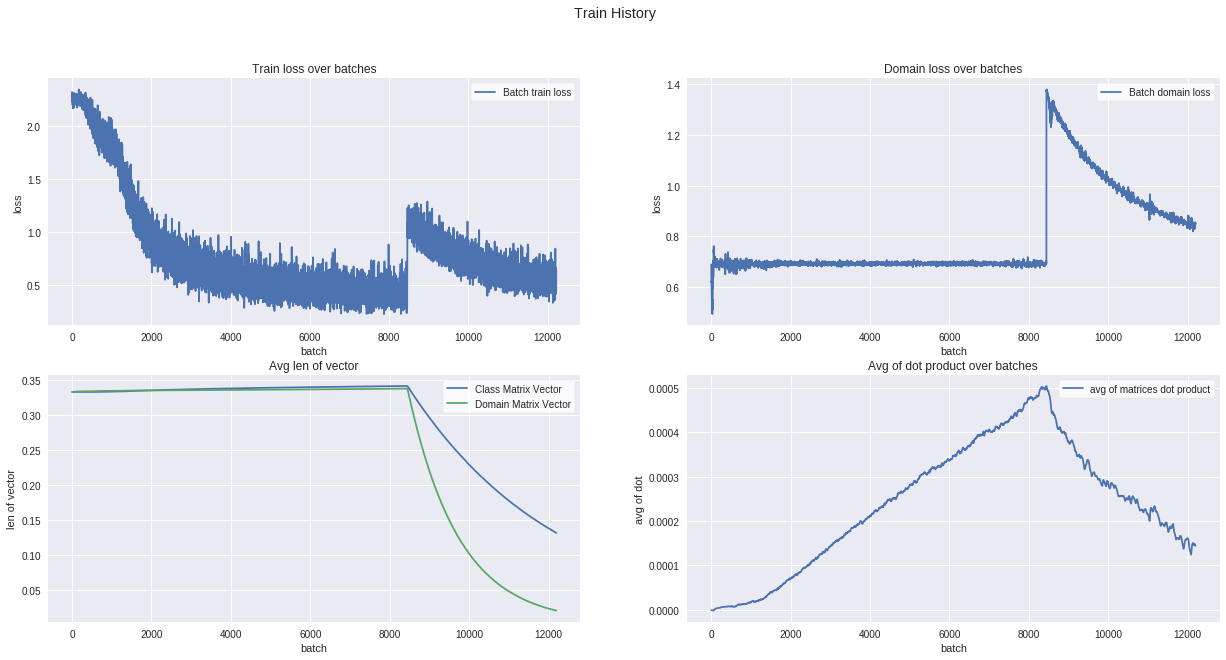

In [95]:
plots.plot_training(new_trainer2.train_history)

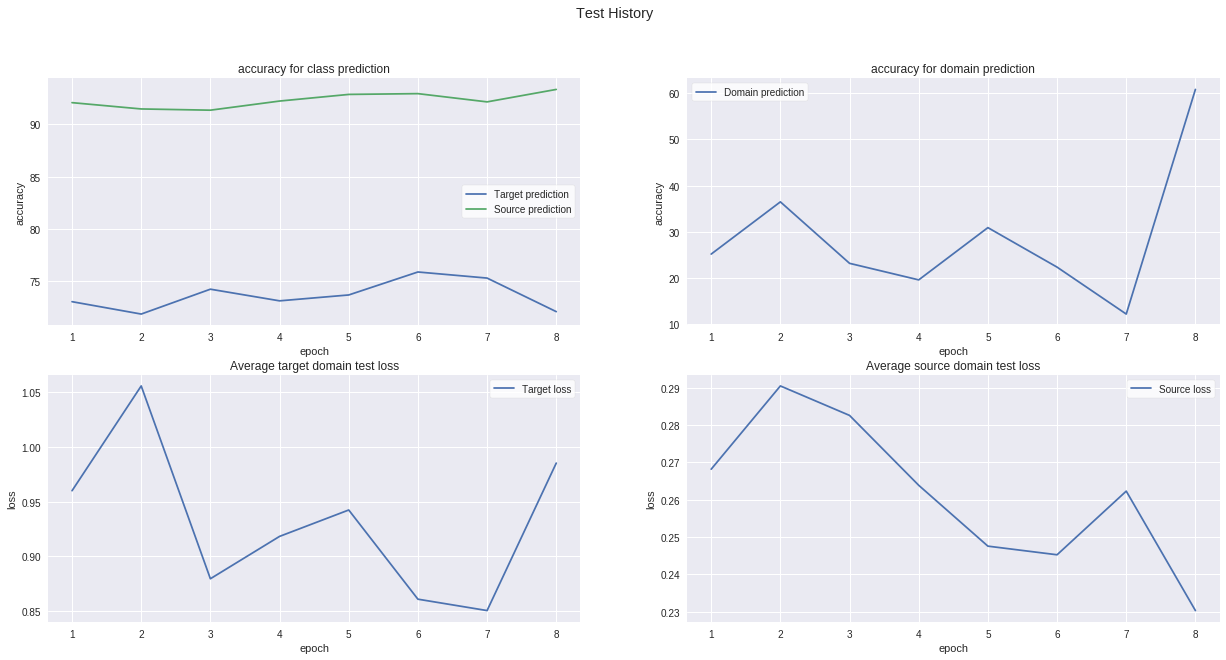

In [96]:
plots.plot_test(test_history_next2)

## Regular continuation 

In [0]:
new_trainer3 = copy.deepcopy(model_trainer_gr)

In [125]:
new_trainer3._test_domain_model(loaders, defaultdict(lambda:[]))


Target Domain Test set: Average loss: 1.1220, Accuracy: 6836/10000 (68%)
Source Domain Test set: Average loss: 0.2538, Accuracy: 67831/73257 (93%)
Domains predictor:  Accuracy: 13092/83257 (16%)



68.36

In [126]:
test_history_gr = defaultdict(lambda:[])
new_trainer3.train(epochs, loaders, test_history=test_history_gr)

Train Epoch: 					1 [0/73257 (0%)]	Loss: 0.466079, lr: 0.01000 lambd: 0.00000
Train Epoch: 					1 [12800/73257 (17%)]	Loss: 0.512414, lr: 0.00903 lambd: 0.07267
Train Epoch: 					1 [25600/73257 (35%)]	Loss: 0.497266, lr: 0.00826 lambd: 0.14459
Train Epoch: 					1 [38400/73257 (52%)]	Loss: 0.439311, lr: 0.00762 lambd: 0.21500
Train Epoch: 					1 [51200/73257 (70%)]	Loss: 0.244622, lr: 0.00709 lambd: 0.28325

Target Domain Test set: Average loss: 1.1809, Accuracy: 6719/10000 (67%)
Source Domain Test set: Average loss: 0.2424, Accuracy: 68186/73257 (93%)
Domains predictor:  Accuracy: 10078/83257 (12%)

Train Epoch: 					2 [0/73257 (0%)]	Loss: 0.380233, lr: 0.00635 lambd: 0.39412
Train Epoch: 					2 [12800/73257 (17%)]	Loss: 0.325681, lr: 0.00599 lambd: 0.45380
Train Epoch: 					2 [25600/73257 (35%)]	Loss: 0.389194, lr: 0.00568 lambd: 0.50966
Train Epoch: 					2 [38400/73257 (52%)]	Loss: 0.377391, lr: 0.00541 lambd: 0.56154
Train Epoch: 					2 [51200/73257 (70%)]	Loss: 0.360449, lr: 0.0051

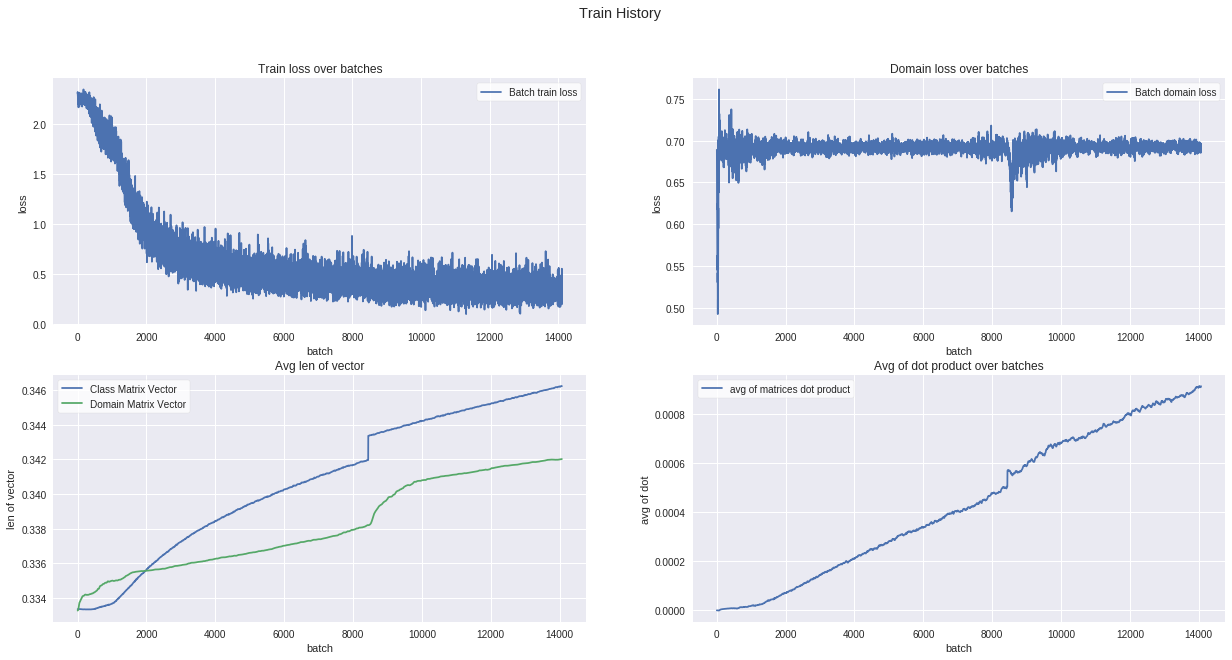

In [137]:
plots.plot_training(new_trainer3.train_history)

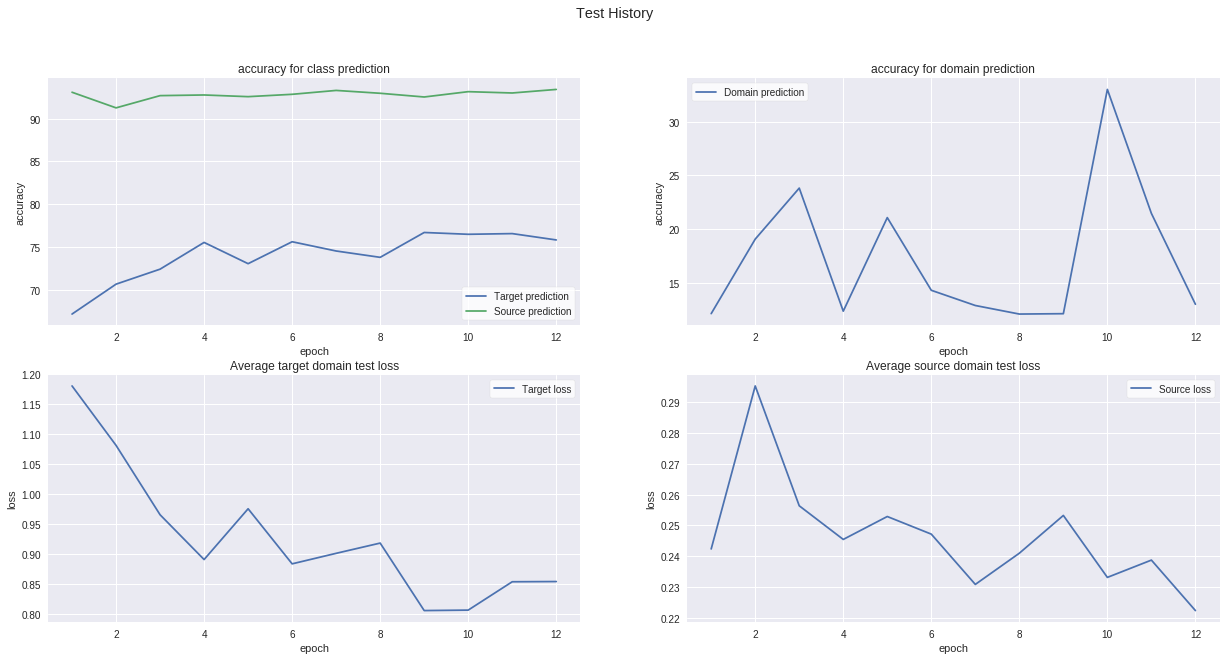

In [138]:
plots.plot_test(test_history_gr)

# Getting new models with lower dimension of feature extractor's representation

In [0]:
model_f = svhn_models.SvhnFeatureExtractor([3,48, 64, 128, 160, 192], pool_stride=2, pool_padding=1).to(device)

In [0]:
output_size = model_f.get_output_size(device)[1]

In [107]:
mfe = [output_size, 512, 256]
model_f_con = models.LinearFromList(mfe)
model_f_ex = models.extend_feature_extractor(model_f, model_f_con, return_size=False).to(device)
model_f_ex

Sequential(
  (0): SvhnFeatureExtractor(
    (conv_layers): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 48, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
        (3): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Dropout(p=0.5)
      )
      (1): Sequential(
        (0): Conv2d(48, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
        (3): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Dropout(p=0.5)
      )
      (2): Sequential(
        (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [0]:
mf = [256]
mc = [256, 512, 512]
md = [256, 512, 512]

In [0]:
_, model_c, model_d = models.get_models(mf, mc, md, use_gr=True)
model_c, model_d = model_c.to(device), model_d.to(device)

In [0]:
optim_f = optim.SGD(model_f_ex.parameters(), lr=lr, momentum=momentum, nesterov=True)
optim_c = optim.SGD(model_c.parameters(), lr=lr, momentum=momentum, nesterov=True)
optim_d = optim.SGD(model_d.parameters(), lr=lr, momentum=momentum, nesterov=True)

In [0]:
train_models = Models(model_f_ex, model_c, model_d)
optims = Optims(optim_f, optim_c, optim_d)

In [0]:
model_trainer_gr_ex = trainer.Trainer(train_models, optims, criterions, device, train_domain=True, tune_lr=True)

In [113]:
test_history_gr = defaultdict(lambda:[])
model_trainer_gr_ex.train(epochs, loaders, test_history=test_history_gr)

Train Epoch: 					1 [0/73257 (0%)]	Loss: 2.304495, lr: 0.01000 lambd: 0.00000
Train Epoch: 					1 [12800/73257 (17%)]	Loss: 2.280154, lr: 0.00903 lambd: 0.07267
Train Epoch: 					1 [25600/73257 (35%)]	Loss: 2.266993, lr: 0.00826 lambd: 0.14459
Train Epoch: 					1 [38400/73257 (52%)]	Loss: 2.195451, lr: 0.00762 lambd: 0.21500
Train Epoch: 					1 [51200/73257 (70%)]	Loss: 2.279993, lr: 0.00709 lambd: 0.28325

Target Domain Test set: Average loss: 2.3226, Accuracy: 1135/10000 (11%)
Source Domain Test set: Average loss: 2.2430, Accuracy: 13861/73257 (19%)
Domains predictor:  Accuracy: 10000/83257 (12%)

Train Epoch: 					2 [0/73257 (0%)]	Loss: 2.188630, lr: 0.00635 lambd: 0.39412
Train Epoch: 					2 [12800/73257 (17%)]	Loss: 2.268160, lr: 0.00599 lambd: 0.45380
Train Epoch: 					2 [25600/73257 (35%)]	Loss: 2.228279, lr: 0.00568 lambd: 0.50966
Train Epoch: 					2 [38400/73257 (52%)]	Loss: 2.203544, lr: 0.00541 lambd: 0.56154
Train Epoch: 					2 [51200/73257 (70%)]	Loss: 2.170142, lr: 0.0051

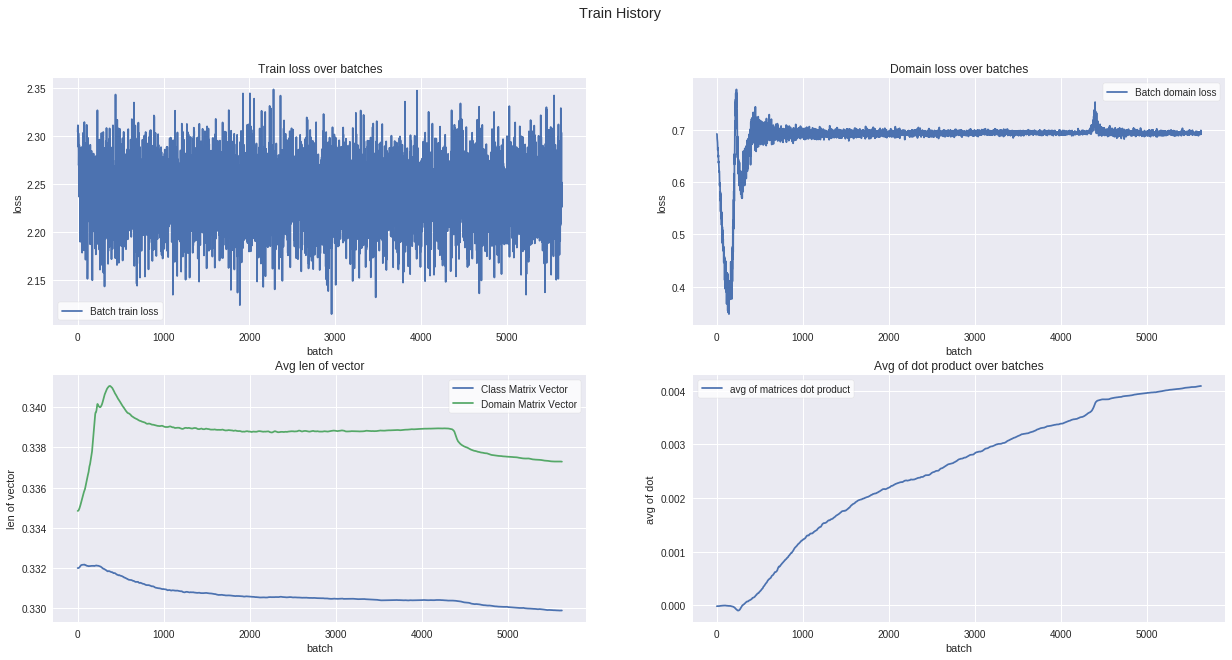

In [114]:
plots.plot_training(model_trainer_gr_ex.train_history)

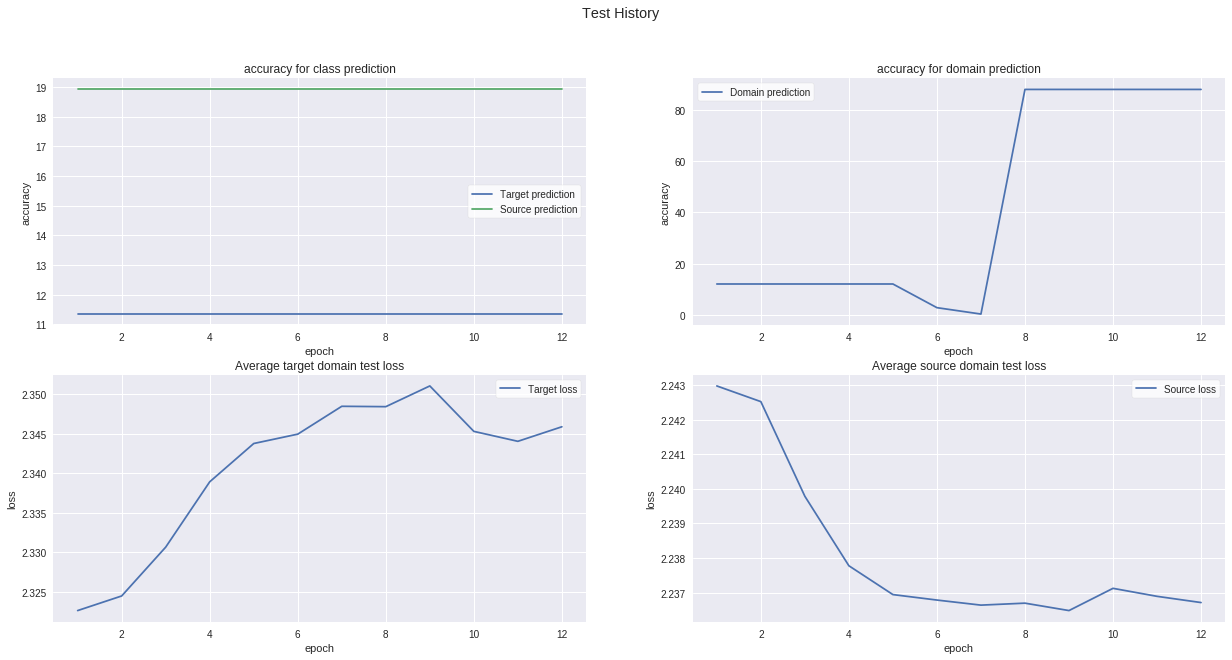

In [115]:
plots.plot_test(test_history_gr)

# Domain vanishing research

In [0]:
def test_domain(test_models, loaders, criterions, device, epochs):
  input_size = test_models.model_c.get_mtx().weight.size()[1]
  domain_pred = models.DomainPredictor(input_size=input_size).to(device)
  domain_optim = optim.Adam(domain_pred.parameters(), lr=lr)
  models_dom = Models(test_models.model_f, None, domain_pred)
  optims_dom = Optims(None, None, optim_d=domain_optim)
  mnist_domain_trainer = domain_trainer.DomainTrainer(models_dom, optims_dom, criterions, device, print_logs=False)
  domain_train_history = defaultdict(lambda:[])
  mnist_domain_trainer.train(epochs, loaders, None, train_history=domain_train_history)
  return domain_train_history

In [0]:
def get_next_models(train_models, device, freeze_model=True):
  if len(train_models.model_c.linears) == 0:
    return Models(None, None, None)
  model_c_f, model_c_c = train_models.model_c.split(1)
  model_c_f, model_c_c = model_c_f.to(device), model_c_c.to(device)
  new_model_f, input_size = models.extend_feature_extractor(train_models.model_f, model_c_f,
                                                           freeze_model=freeze_model)
  new_model_f=new_model_f.to(device)
  model_d = models.MnistDomain(input_size=input_size).to(device)
  return Models(new_model_f, model_c_c, model_d)

In [0]:
def domain_vainshing_research(train_models, optims, loaders, criterions,device,
                              epochs, freeze_model=True, print_test=True, extra_loss=None, tune_lr=True):
  trainers = []
  tests_histories = []
  domain_histories = []
  domain_gr_histories = []
  model_c_len = len(model_c.linears)
  while train_models.model_c is not None:
    domain_gr_histories.append(test_domain(train_models, loaders, criterions, device, epochs))
    if print_test:
      print('Model_c layers: {} Domain prediction on Feature Extractor after GR: {}'.format(
             model_c_len+1, domain_gr_histories[-1]['acc']))
    
    train_models = get_next_models(train_models, device, freeze_model=freeze_model)
    model_c_len -= 1
    if model_c_len < 0:
      break
    domain_histories.append(test_domain(train_models, loaders, criterions, device, epochs))    
    if print_test:
      print("Domain prediction on Class Predictor's first layer",
            domain_histories[-1]['acc'])    
    
    optim_f = optim.Adam(train_models.model_f.parameters(), lr=lr)
    optim_c = optim.Adam(train_models.model_c.parameters(), lr=lr)
    optim_d = optim.Adam(train_models.model_d.parameters(), lr=lr)
    optims = Optims(optim_f, optim_c, optim_d)    
    trainers.append(trainer.Trainer(train_models, optims, criterions, device, tune_lr=tune_lr, print_logs=False))
    tests_histories.append(defaultdict(lambda:[]))
    trainers[-1].train(epochs, loaders, extra_loss=extra_loss, test_history=tests_histories[-1])
    if print_test:
      print("Model_c layers: {} Model Accuracy with GR on Class Predictor's first layer: {}".format(
            model_c_len+1, tests_histories[-1]['target_acc']))

  return trainers, tests_histories, domain_histories, domain_gr_histories

In [0]:
domain_vanish_models = copy.deepcopy(model_trainer_gr.best_model)
optim_f = optim.SGD(domain_vanish_models.model_f.parameters(), lr=lr, momentum=momentum, nesterov=True)
optim_c = optim.SGD(domain_vanish_models.model_c.parameters(), lr=lr, momentum=momentum, nesterov=True)
optim_d = optim.SGD(domain_vanish_models.model_d.parameters(), lr=lr, momentum=momentum, nesterov=True)


In [0]:
optims = Optims(optim_f, optim_c, optim_d)

In [0]:
epochs=12

In [103]:
trainers, test_histories, domain_histories, domain_gr_histories = domain_vainshing_research(domain_vanish_models, optims, loaders, criterions, device, epochs)

Model_c layers: 4 Domain prediction on Feature Extractor after GR: [99.80422066613018, 99.57120722581885, 99.8762866785976, 99.83424817132493, 99.702127148468, 99.91952628607805, 99.81142726737691, 99.79220966405227, 99.94114608981828, 99.91832518587026, 99.88829768067549, 99.91472188524689]
Domain prediction on Class Predictor's first layer [99.48232581044236, 99.79821516509122, 99.48713021127352, 99.73215465366276, 99.5279676183384, 99.8378514719483, 99.76098105864972, 99.85827017548074, 99.83184597090936, 99.8138294677925, 99.851063574234, 99.77058986031204]
Model_c layers: 3 Model Accuracy with GR on Class Predictor's first layer: [60.33, 59.14, 63.56, 68.24, 63.03, 65.58, 66.83, 67.27, 63.36, 59.88, 66.76, 63.58]
Model_c layers: 3 Domain prediction on Feature Extractor after GR: [87.98899792209664, 87.98899792209664, 88.20639705970669, 88.86580107378359, 88.06226503477185, 88.90543738064066, 87.9938023229278, 88.11751564433021, 88.7024514455241, 88.53549851664124, 89.7966537348210

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7fe909775198>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  Fil

Model_c layers: 2 Model Accuracy with GR on Class Predictor's first layer: [62.69, 57.53, 63.92, 43.51, 71.1, 55.96, 40.53, 70.81, 66.81, 69.91, 69.81, 69.44]
Model_c layers: 2 Domain prediction on Feature Extractor after GR: [87.98899792209664, 87.98899792209664, 87.91452970921364, 87.98899792209664, 77.24996096424324, 67.3012479431159, 87.98899792209664, 87.9817913208499, 87.98539462147328, 87.99140012251222, 87.98899792209664, 87.98899792209664]
Domain prediction on Class Predictor's first layer [77.42532159458064, 87.98899792209664, 77.7279988469438, 87.99500342313559, 86.61013488355333, 84.18391246381685, 88.14153764848601, 87.71995147555161, 86.3278763347226, 87.46051383066889, 83.95930672496006, 87.87849670297993]
Model_c layers: 1 Model Accuracy with GR on Class Predictor's first layer: [66.96, 67.6, 69.85, 67.93, 66.92, 68.99, 70.76, 67.13, 70.38, 62.2, 70.96, 69.44]
Model_c layers: 1 Domain prediction on Feature Extractor after GR: [87.98899792209664, 82.37865885150798, 87.98

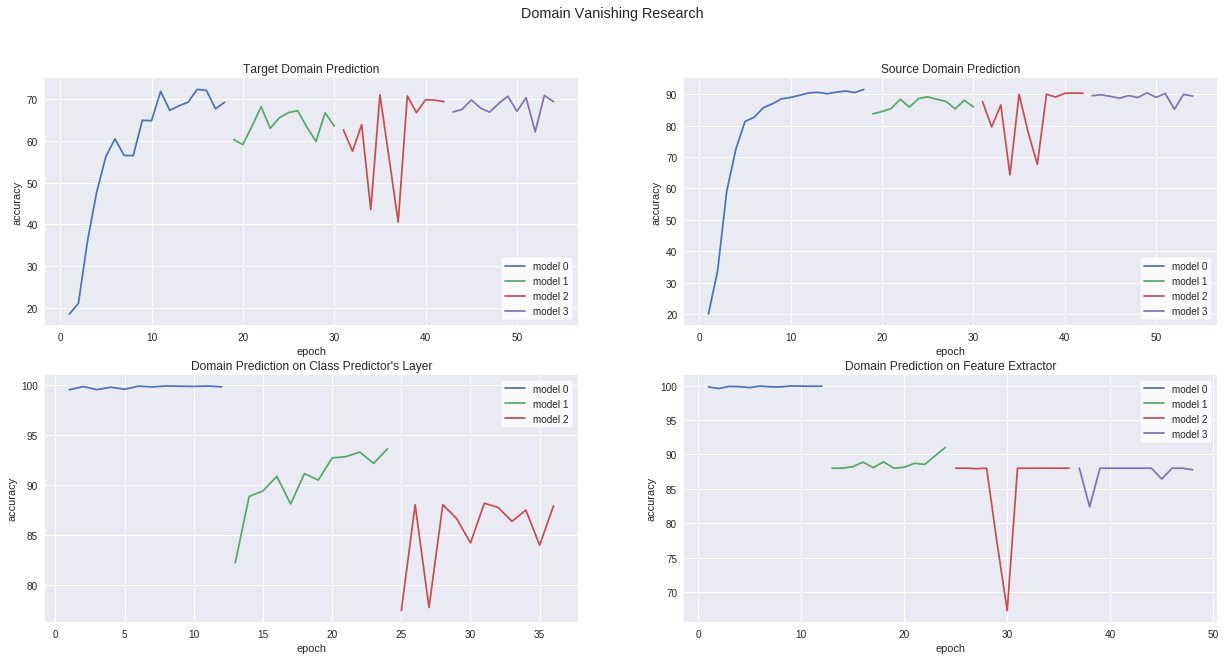

In [104]:
plots.plot_domain_vanishing([model_trainer_gr] + trainers, [test_history_gr] + test_histories, domain_histories, domain_gr_histories)

# Training without GR

In [0]:
model_f = svhn_models.SvhnFeatureExtractor([3,48, 64, 128, 160, 192], pool_stride=2, pool_padding=1).to(device)

In [117]:
output_size = model_f.get_output_size(device)[1]
output_size

768

In [0]:
mf = [output_size]
mc = [output_size, 3072, 2048, 512]
md = [output_size, 1024, 100]

In [0]:
_, model_c, model_d = models.get_models(mf, mc, md, use_gr=False)
model_f, model_c, model_d = model_f.to(device), model_c.to(device), model_d.to(device)

In [0]:
optim_f = optim.SGD(model_f.parameters(), lr=lr, momentum=momentum)
optim_c = optim.SGD(model_c.parameters(), lr=lr, momentum=momentum)
optim_d = optim.SGD(model_d.parameters(), lr=lr, momentum=momentum)

In [0]:
train_models = Models(model_f, model_c, model_d)
optims = Optims(optim_f, optim_c, optim_d)

In [0]:
model_trainer_no_gr = trainer.Trainer(train_models, optims, criterions, device, train_domain=True, tune_lr=True)

In [123]:
test_history_no_gr = defaultdict(lambda:[])
model_trainer_no_gr.train(epochs, loaders, test_history=test_history_no_gr)

Train Epoch: 					1 [0/73257 (0%)]	Loss: 2.305144, lr: 0.01000 lambd: 0.00000
Train Epoch: 					1 [12800/73257 (17%)]	Loss: 2.225340, lr: 0.00903 lambd: 0.07267
Train Epoch: 					1 [25600/73257 (35%)]	Loss: 2.223325, lr: 0.00826 lambd: 0.14459
Train Epoch: 					1 [38400/73257 (52%)]	Loss: 2.247181, lr: 0.00762 lambd: 0.21500
Train Epoch: 					1 [51200/73257 (70%)]	Loss: 2.234880, lr: 0.00709 lambd: 0.28325

Target Domain Test set: Average loss: 2.3205, Accuracy: 1135/10000 (11%)
Source Domain Test set: Average loss: 2.2369, Accuracy: 13861/73257 (19%)
Domains predictor:  Accuracy: 270/83257 (0%)

Train Epoch: 					2 [0/73257 (0%)]	Loss: 2.253988, lr: 0.00635 lambd: 0.39412
Train Epoch: 					2 [12800/73257 (17%)]	Loss: 2.238465, lr: 0.00599 lambd: 0.45380
Train Epoch: 					2 [25600/73257 (35%)]	Loss: 2.244092, lr: 0.00568 lambd: 0.50966
Train Epoch: 					2 [38400/73257 (52%)]	Loss: 2.245859, lr: 0.00541 lambd: 0.56154
Train Epoch: 					2 [51200/73257 (70%)]	Loss: 2.183495, lr: 0.00516 l

# Adam Optimizer

In [0]:
model_f = svhn_models.SvhnFeatureExtractor([3,48, 64, 128, 160, 192], pool_stride=2, pool_padding=1).to(device)

In [0]:
output_size = model_f.get_output_size(device)[1]

In [0]:
mf = [output_size]
mc = [output_size, 3072, 2048, 512]
md = [output_size, 1024, 100]

In [0]:
_, model_c, model_d = models.get_models(mf, mc, md, use_gr=True)
model_f, model_c, model_d = model_f.to(device), model_c.to(device), model_d.to(device)

In [0]:
lr=0.0005
optim_f = optim.Adam(model_f.parameters(), lr=lr)
optim_c = optim.Adam(model_c.parameters(), lr=lr)
optim_d = optim.Adam(model_d.parameters(), lr=lr)

In [0]:
train_models = Models(model_f, model_c, model_d)
optims = Optims(optim_f, optim_c, optim_d)

In [0]:
model_trainer_adam = trainer.Trainer(train_models, optims, criterions, device, train_domain=True)

In [134]:
test_history_adam = defaultdict(lambda:[])
model_trainer_adam.train(epochs, loaders, test_history=test_history_adam)

Train Epoch: 					1 [0/73257 (0%)]	Loss: 2.300204, lr: 0.00000 lambd: 0.00000
Train Epoch: 					1 [12800/73257 (17%)]	Loss: 2.164072, lr: 0.00000 lambd: 0.07267
Train Epoch: 					1 [25600/73257 (35%)]	Loss: 1.858707, lr: 0.00000 lambd: 0.14459
Train Epoch: 					1 [38400/73257 (52%)]	Loss: 1.659203, lr: 0.00000 lambd: 0.21500
Train Epoch: 					1 [51200/73257 (70%)]	Loss: 1.464969, lr: 0.00000 lambd: 0.28325

Target Domain Test set: Average loss: 1.8839, Accuracy: 4411/10000 (44%)
Source Domain Test set: Average loss: 1.0442, Accuracy: 47148/73257 (64%)
Domains predictor:  Accuracy: 42871/83257 (51%)

Train Epoch: 					2 [0/73257 (0%)]	Loss: 1.317614, lr: 0.00000 lambd: 0.39412
Train Epoch: 					2 [12800/73257 (17%)]	Loss: 1.068441, lr: 0.00000 lambd: 0.45380
Train Epoch: 					2 [25600/73257 (35%)]	Loss: 1.043571, lr: 0.00000 lambd: 0.50966
Train Epoch: 					2 [38400/73257 (52%)]	Loss: 0.913417, lr: 0.00000 lambd: 0.56154
Train Epoch: 					2 [51200/73257 (70%)]	Loss: 0.891554, lr: 0.0000

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7fe910f10b70>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  Fil


Target Domain Test set: Average loss: 1.4439, Accuracy: 6039/10000 (60%)
Source Domain Test set: Average loss: 0.4750, Accuracy: 62696/73257 (86%)
Domains predictor:  Accuracy: 17298/83257 (21%)

Train Epoch: 					4 [0/73257 (0%)]	Loss: 0.577975, lr: 0.00000 lambd: 0.84828
Train Epoch: 					4 [12800/73257 (17%)]	Loss: 0.604270, lr: 0.00000 lambd: 0.86748
Train Epoch: 					4 [25600/73257 (35%)]	Loss: 0.749219, lr: 0.00000 lambd: 0.88440
Train Epoch: 					4 [38400/73257 (52%)]	Loss: 0.554325, lr: 0.00000 lambd: 0.89927
Train Epoch: 					4 [51200/73257 (70%)]	Loss: 0.549295, lr: 0.00000 lambd: 0.91232

Target Domain Test set: Average loss: 1.2757, Accuracy: 6468/10000 (65%)
Source Domain Test set: Average loss: 0.4072, Accuracy: 64471/73257 (88%)
Domains predictor:  Accuracy: 24812/83257 (30%)

Train Epoch: 					5 [0/73257 (0%)]	Loss: 0.590164, lr: 0.00000 lambd: 0.93111
Train Epoch: 					5 [12800/73257 (17%)]	Loss: 0.530170, lr: 0.00000 lambd: 0.94017
Train Epoch: 					5 [25600/73257 (3

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7fe910dda898>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/lib/python3.6/multiprocessing/reduction.py", line 182, in recv_handle
    return recvfds(s, 1)[0]
  File "/usr/lib/python3.6/multiprocessing/reduction.py", line 153, in re


Target Domain Test set: Average loss: 1.0496, Accuracy: 7341/10000 (73%)
Source Domain Test set: Average loss: 0.3033, Accuracy: 66719/73257 (91%)
Domains predictor:  Accuracy: 19680/83257 (24%)

Train Epoch: 					12 [0/73257 (0%)]	Loss: 0.450968, lr: 0.00000 lambd: 0.99979
Train Epoch: 					12 [12800/73257 (17%)]	Loss: 0.508728, lr: 0.00000 lambd: 0.99982
Train Epoch: 					12 [25600/73257 (35%)]	Loss: 0.506441, lr: 0.00000 lambd: 0.99984
Train Epoch: 					12 [38400/73257 (52%)]	Loss: 0.493567, lr: 0.00000 lambd: 0.99987
Train Epoch: 					12 [51200/73257 (70%)]	Loss: 0.362011, lr: 0.00000 lambd: 0.99988

Target Domain Test set: Average loss: 1.0268, Accuracy: 7498/10000 (75%)
Source Domain Test set: Average loss: 0.2701, Accuracy: 67473/73257 (92%)
Domains predictor:  Accuracy: 29142/83257 (35%)



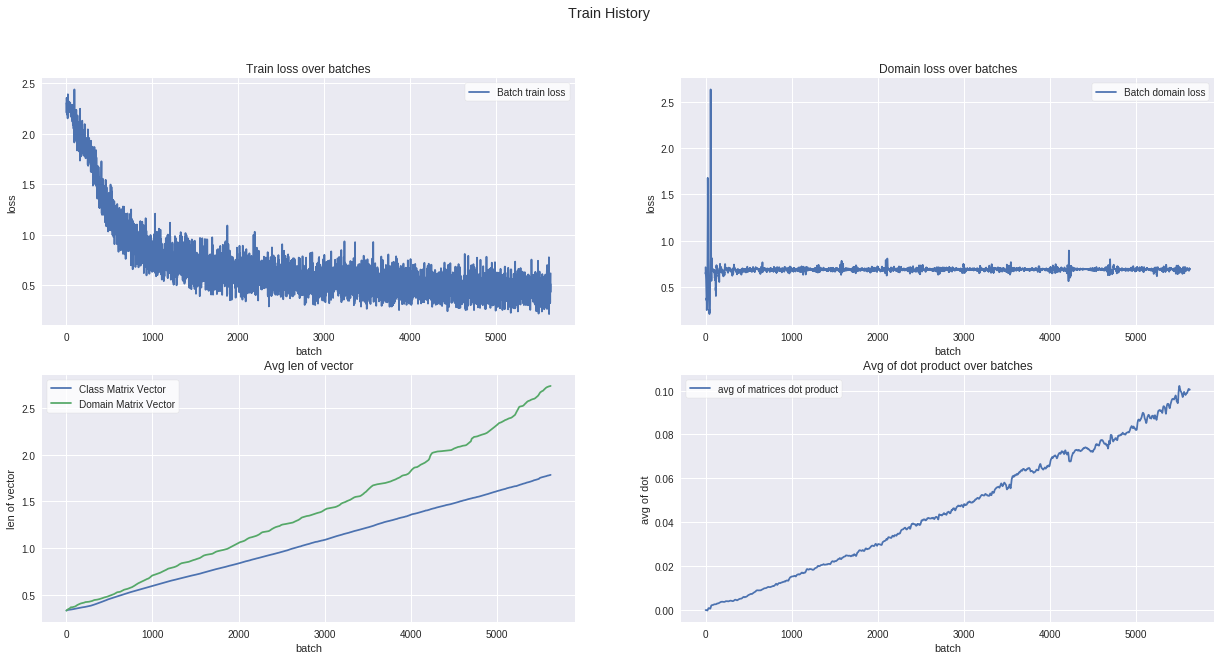

In [135]:
plots.plot_training(model_trainer_adam.train_history)

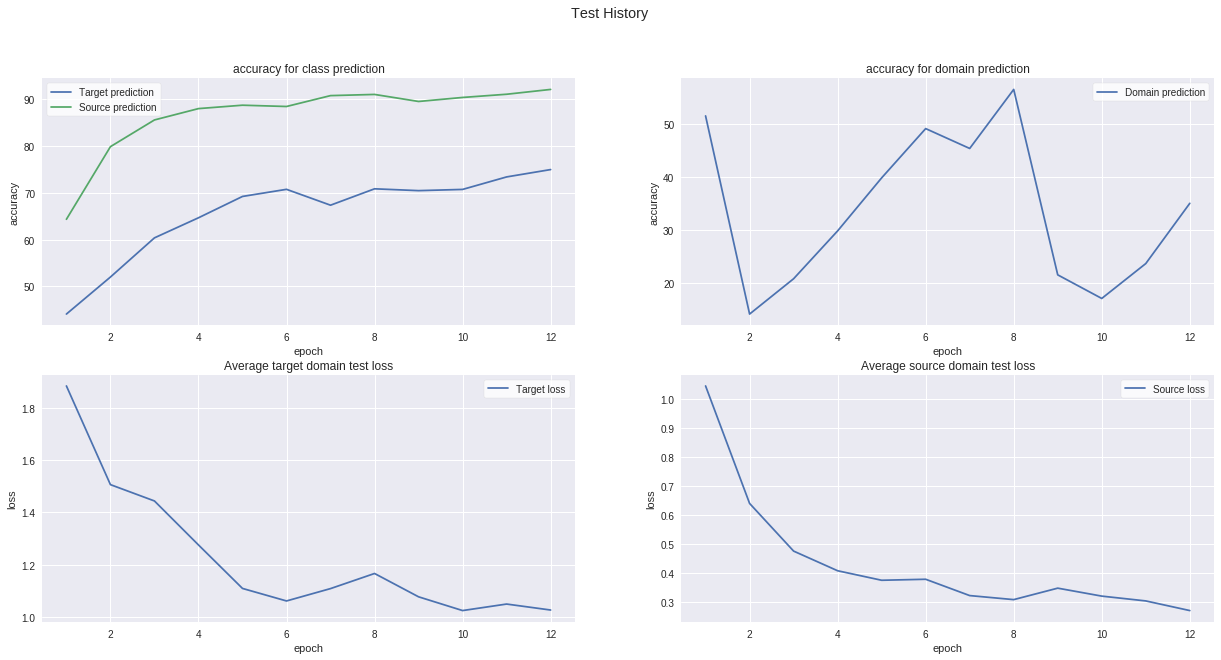

In [136]:
plots.plot_test(test_history_adam)